In [42]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [43]:
words = open('../data/names.txt', 'r').read().splitlines()

In [44]:
len(words)

32033

In [45]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [46]:
chars = sorted(list(set(''.join(words))))

# util

In [47]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [48]:
stoi = {s: i for i, s in itos.items()}

In [49]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [50]:
BLOCK_SIZE = 3
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [51]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# indexing and embeding

In [52]:
C = torch.randn(len(itos), 2)
C[:5]

tensor([[ 1.1718, -0.2888],
        [ 0.2830, -1.2521],
        [-0.7285, -0.8975],
        [ 1.3263, -0.7175],
        [-0.0597, -1.6344]])

In [53]:
tmp = torch.tensor([[2, 3,3],
                   [1,0,0]])

In [54]:
C[2]

tensor([-0.7285, -0.8975])

In [55]:
C[tmp][0,0]

tensor([-0.7285, -0.8975])

# torch.cat vs torch.view

In [56]:
emb = C[Xtr][:4]

In [57]:
emb.shape

torch.Size([4, 3, 2])

In [58]:
emb

tensor([[[ 1.1718, -0.2888],
         [ 1.1718, -0.2888],
         [ 1.1718, -0.2888]],

        [[ 1.1718, -0.2888],
         [ 1.1718, -0.2888],
         [ 0.1501,  0.4812]],

        [[ 1.1718, -0.2888],
         [ 0.1501,  0.4812],
         [-0.8169, -1.7340]],

        [[ 0.1501,  0.4812],
         [-0.8169, -1.7340],
         [ 0.4736,  0.7909]]])

In [59]:
emb[:,0,:]

tensor([[ 1.1718, -0.2888],
        [ 1.1718, -0.2888],
        [ 1.1718, -0.2888],
        [ 0.1501,  0.4812]])

In [60]:
emb[:,:,0]

tensor([[ 1.1718,  1.1718,  1.1718],
        [ 1.1718,  1.1718,  0.1501],
        [ 1.1718,  0.1501, -0.8169],
        [ 0.1501, -0.8169,  0.4736]])

In [61]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1)

tensor([[ 1.1718, -0.2888,  1.1718, -0.2888,  1.1718, -0.2888],
        [ 1.1718, -0.2888,  1.1718, -0.2888,  0.1501,  0.4812],
        [ 1.1718, -0.2888,  0.1501,  0.4812, -0.8169, -1.7340],
        [ 0.1501,  0.4812, -0.8169, -1.7340,  0.4736,  0.7909]])

In [62]:
emb2 = emb.swapaxes(1,2)

In [63]:
torch.cat([emb2[:,:,0], emb2[:,:,1], emb2[:,:,2]],1)

tensor([[ 1.1718, -0.2888,  1.1718, -0.2888,  1.1718, -0.2888],
        [ 1.1718, -0.2888,  1.1718, -0.2888,  0.1501,  0.4812],
        [ 1.1718, -0.2888,  0.1501,  0.4812, -0.8169, -1.7340],
        [ 0.1501,  0.4812, -0.8169, -1.7340,  0.4736,  0.7909]])

In [64]:
emb.view(-1, 6)

tensor([[ 1.1718, -0.2888,  1.1718, -0.2888,  1.1718, -0.2888],
        [ 1.1718, -0.2888,  1.1718, -0.2888,  0.1501,  0.4812],
        [ 1.1718, -0.2888,  0.1501,  0.4812, -0.8169, -1.7340],
        [ 0.1501,  0.4812, -0.8169, -1.7340,  0.4736,  0.7909]])

In [65]:
(torch.cat(torch.unbind(emb, 1),1) == emb.view(-1, 6)).all()

tensor(True)

In [66]:
(torch.cat(torch.unbind(emb2, 2),1) == emb.view(-1, 6)).all()

tensor(True)

In [67]:
(torch.cat(torch.unbind(emb, 2),1) == emb.view(-1, 6)).all()

tensor(False)

In [68]:
(torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1) == emb.view(-1, 6)).all()

tensor(True)

In [69]:
(torch.cat([emb[:,:,0], emb[:,:,1]],1) == emb.view(-1, 6)).all()

tensor(False)

In [70]:
(torch.cat([emb2[:,:,0], emb2[:,:,1], emb2[:,:,2]],1) == emb.view(-1, 6)).all()

tensor(True)

In [71]:
torch.cat([emb[:,:,0], emb[:,:,1]],1).shape

torch.Size([4, 6])

# figuring out learning rate

In [72]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [73]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*BLOCK_SIZE, HIDDEN_DIM)
b1 = torch.randn(HIDDEN_DIM)
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01
parameters = [C, w1, b1, w2, b2]

In [74]:
for p in parameters:
    p.requires_grad = True

In [75]:
loglossi = []
lossi = []

In [76]:
lre = torch.linspace(-3, 0, 1000)
lri = 10**lre

In [77]:
#STEPS = 800_000
STEPS = 1_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = 0.1 if i < STEPS//2 else 0.01
    lr = lri[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2118.94it/s]


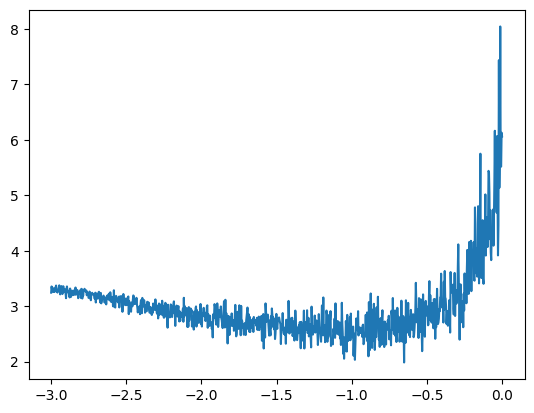

In [78]:
plt.plot(lre, lossi);

# Train a neural language model

In [88]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [89]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*BLOCK_SIZE, HIDDEN_DIM)
b1 = torch.randn(HIDDEN_DIM)
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01
parameters = [C, w1, b1, w2, b2]

In [90]:
sum(p.nelement() for p in parameters)

11897

In [91]:
for p in parameters:
    p.requires_grad = True

In [92]:
loglossi = []
lossi = []

In [93]:
# STEPS = 800_000
STEPS = 200_000
# STEPS = 10_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████| 200000/200000 [01:13<00:00, 2725.51it/s]


In [94]:
h.shape, w2.shape, b2.shape

(torch.Size([32, 200]), torch.Size([200, 27]), torch.Size([27]))

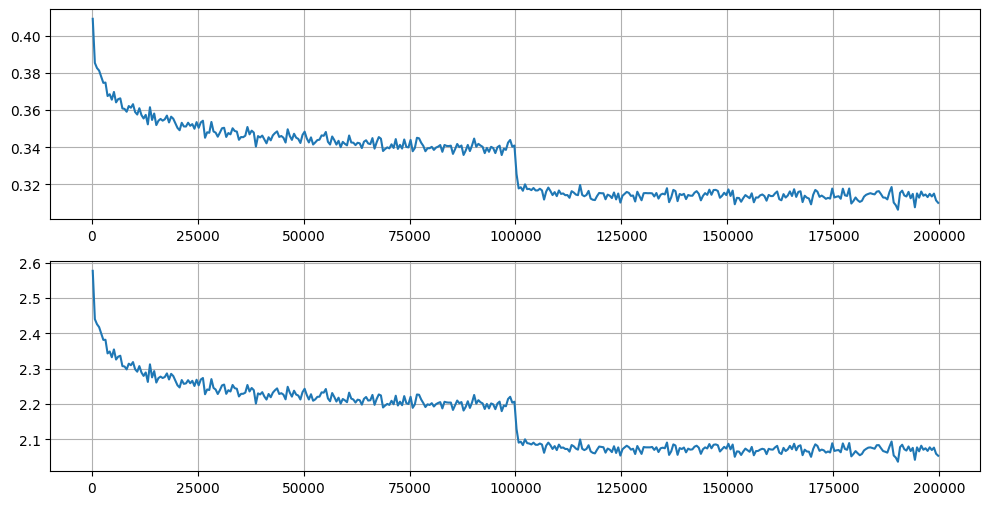

In [105]:
group_size = 500
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(
    torch.arange(len(loglossi)).view(-1, group_size).float().mean(1),
    torch.tensor(loglossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.subplot(212)
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

## compute loss on train/dev/test

In [106]:
def eval_dataset(X, Y):
    with torch.no_grad():
        emb = C[X] # (32, 3, 2)
        h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
        logits = h @ w2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [107]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.068862199783325
2.1316521167755127


## visualize the embedding

In [108]:
from sklearn.manifold import TSNE

In [109]:
tsne = TSNE(n_components=2, verbose=1, random_state=1235, perplexity=5)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [110]:
z = tsne.fit_transform(C.detach().numpy())

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 1.534512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.608864
[t-SNE] KL divergence after 1000 iterations: 0.411436


In [111]:
C.shape, z.shape

(torch.Size([27, 10]), (27, 2))

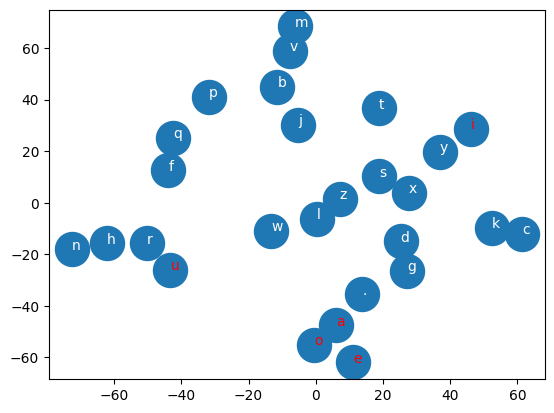

In [112]:
plt.scatter(z[:,0].data, z[:,1].data, s=600)
for i in range(z.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(z[i,0].item(), z[i,1].item(), itos[i], color=c)

# generate names

In [113]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [114]:
for _ in range(10):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        emb = C[torch.tensor([context])]
        h = (emb.view(1, -1) @ w1 + b1).tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
milia.
atlannah.
sketa.
hutn.
deliah.
jareei.
ner.
